In [1]:
!pip install transformers datasets -q 

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "IrshadG/Clothes_Classification_hnm_1"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)
hidden_dim = model.config.hidden_size

c:\Users\sahin\Desktop\deeplearning\test\midterm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sahin\Desktop\deeplearning\test\midterm\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at IrshadG/Clothes_Classification_hnm_1 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the "images" folder containing the first 100 images
images_folder_path = "./updated_dataset"

# Get all files
all_files = os.listdir(images_folder_path)

# Filter only files with the .jpg extension
image_files = [file for file in all_files if file.endswith(".jpg")]

# Select the first 100 files
selected_image_files = image_files[:500]

# Create a dataset dictionary (for example)
dataset = {"train": []}

# Store filenames
filenames = []

# Add the selected first 100 files to dataset["train"]
for image_filename in selected_image_files:
    image_path = os.path.join(images_folder_path, image_filename)

    # Load the image and convert it to a numpy array (if necessary)
    image = np.array(Image.open(image_path))

    # Add to the dataset
    dataset["train"].append({"image": image})
    filenames.append(image_filename)


In [5]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [6]:
num_samples = 100
seed = 42
hash_size = 8
np.random.seed(seed)


# Define random vectors to project with.
random_vectors = np.random.randn(hash_size, hidden_dim).T


def hash_func(embedding, random_vectors=random_vectors):
    """Randomly projects the embeddings and then computes bit-wise hashes."""
    if not isinstance(embedding, np.ndarray):
        embedding = np.array(embedding)
    if len(embedding.shape) < 2:
        embedding = np.expand_dims(embedding, 0)

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y

In [7]:
from typing import Union

def compute_hash(model: Union[torch.nn.Module, str]):
    """Computes hash on a given dataset."""
    device = model.device

    def pp(example_batch):
        # Prepare the input images for the model.
        image_batch = example_batch["image"]
        
        for i, image in enumerate(image_batch):
            original_image = Image.fromarray(np.uint8(image))
            image_batch[i] = original_image

        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in image_batch]
        )

        new_batch = {"pixel_values": image_batch_transformed.to(device)}

        # Compute embeddings and pool them i.e., take the representations from the [CLS]
        # token.
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu().numpy()

        # Compute hashes for the batch of images.
        hashes = [hash_func(embeddings[i]) for i in range(len(embeddings))]
        example_batch["hashes"] = hashes
        return example_batch

    return pp

In [8]:
from typing import List


class Table:
    def __init__(self, hash_size: int):
        self.table = {}
        self.hash_size = hash_size

    def add(self, id: int, hashes: List[int], image_name: str):
        # Create a unique indentifier.
        entry = {"id": str(id), "image_name": image_name}

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, hashes: List[int]):
        results = []

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results

In [9]:
class LSH:
    def __init__(self, hash_size, num_tables):
        self.num_tables = num_tables
        self.tables = []
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size))

    def add(self, id: int, hash: List[int], image_name):
        for table in self.tables:
            table.add(id, hash, image_name)

    def query(self, hashes: List[int]):
        results = []
        for table in self.tables:
            results.extend(table.query(hashes))
        return results

In [10]:
from PIL import Image
import datasets
import torch
from tqdm.auto import tqdm
import pickle

class BuildLSHTable:
    def __init__(
        self,
        model: Union[torch.nn.Module, None],
        batch_size: int = 48,
        hash_size: int = hash_size,
        dim: int = hidden_dim,
        num_tables: int = 10,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.num_tables)

        self.batch_size = batch_size
        self.hash_fn = compute_hash(model.to(device))

    def build(self, ds: datasets.DatasetDict):
        dataset_hashed = ds.map(self.hash_fn, batched=True, batch_size=self.batch_size)
        for id in tqdm(range(len(dataset_hashed))):
            hash = dataset_hashed[id]["hashes"]
            index = filenames[id].find('.')
            if index != -1:
                filenames[id]=filenames[id][:index]
                self.lsh.add(id, hash, filenames[id])

    def query(self, image, verbose=True):
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # Compute the hashes of the query image and fetch the results.
        example_batch = dict(image=[image])
        hashes = self.hash_fn(example_batch)["hashes"][0]

        results = self.lsh.query(hashes)
        if verbose:
            print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts_and_names = {}
        for r in results:
            if r["id"] in counts_and_names:
                counts_and_names[r["id"]]["count"] += 1
            else:
                counts_and_names[r["id"]] = {"count": 1, "image_name": r["image_name"]}

        # Normalize counts
        for k in counts_and_names:
            counts_and_names[k]["count"] = float(counts_and_names[k]["count"]) / self.dim

        return counts_and_names
    
    def save_lsh_table(self, filename="lsh_table.pkl"):
        with open(filename, "wb") as file:
            pickle.dump(self.lsh, file)
        print(f"LSH table saved to {filename}")

In [11]:
# from datasets import Dataset

# lsh_builder = BuildLSHTable(model)
# images_list = dataset["train"]
# dataset_dict = {"image": [item["image"] for item in images_list]}

# # Create a datasets.Dataset object
# ds = Dataset.from_dict(dataset_dict)
# # Now you can use the map method
# lsh_builder.build(ds)
# lsh_builder.save_lsh_table()

In [12]:
# Load the saved LSH table
with open("lsh_table.pkl", "rb") as file:
    loaded_lsh = pickle.load(file)

# # Create a new instance of LSH
lsh_builder = BuildLSHTable(model)
lsh_builder.lsh = loaded_lsh

In [13]:
idx = 0
for hash, entry in lsh_builder.lsh.tables[0].table.items():
    if idx == 5:
        break
    if len(entry) < 5:
        print(f"Hash: {hash}, entries: {entry}")
        idx += 1

Hash: 63, entries: [{'id': '1', 'image_name': '1--3-vH3x7GpmZP0lPLAk6_Qby5GYB8bd'}, {'id': '272', 'image_name': '10oCOb1X1Ffr9cBzQW3k0yla2EzznkrcO'}, {'id': '468', 'image_name': '11tz8GOVFPYz3cRTla0gXQwI2BssQI-2e'}]
Hash: 222, entries: [{'id': '4', 'image_name': '1--OmSs2EoBH0glTjtcDSGLM-hc2oRvcA'}, {'id': '307', 'image_name': '10UNZy6RRzEHPlSEdvQoyaR3Lm8Oewtw0'}]
Hash: 24, entries: [{'id': '8', 'image_name': '1-0mdUAapD8-LFuBSbDWJUzJMLQlhwD0C'}, {'id': '308', 'image_name': '10vj3l33-LItfOzWYRhJ7lUoZb21J3QYJ'}, {'id': '363', 'image_name': '11BANKidE-xD318wOOjWIbhmgk5Mkg9Kd'}, {'id': '472', 'image_name': '11uVhoIYFXre7Wf0drY5WQspsP-dpexy6'}]
Hash: 93, entries: [{'id': '9', 'image_name': '1-0pYZmbFNRZ3mLKHn8xP7IWX_rIwDRFB'}]
Hash: 56, entries: [{'id': '12', 'image_name': '1-1hb223U7djmNXvmcwJfHexvqjhQpyfX'}, {'id': '280', 'image_name': '10pTZnUATuOUuAyZ_7Wf8XKiQGOlc7wfI'}]


In [14]:
import os
import numpy as np
from PIL import Image
from IPython.display import display

def visualize_lsh(lsh_class: BuildLSHTable):
    # Path to the new image
    new_image_path = "./saat.jpg"
    # Load the new image as a numpy array
    new_image = np.array(Image.open(new_image_path))
    # Convert the numpy array back to a PIL image
    image_pil = Image.fromarray(new_image)

    # Query the LSH table to get similar images
    results = lsh_class.query(image_pil)

    # Create a list to store all images to display
    images_to_display = []
    
    for _, info in results.items():
        # Construct the updated image name by adding ".jpg" to the image name
        updated_image_name = info["image_name"] + ".jpg"
        # Construct the updated image path
        updated_image_path = os.path.join("updated_dataset", updated_image_name)
        
        # If the file exists, display it
        if os.path.exists(updated_image_path):
            updated_image = Image.open(updated_image_path)
            images_to_display.append(updated_image)
        else:
            print(f"File not found: {updated_image_path}")
    
    # Combine all images
    if images_to_display:
        # Set frame dimensions based on the first image
        frame_width, frame_height = images_to_display[0].size
        # Expand the frame width
        combined_image = Image.new('RGB', (frame_width * len(images_to_display), frame_height))
        
        # Paste images onto the frame
        for i, img in enumerate(images_to_display):
            combined_image.paste(img, (i * frame_width, 0))
        
        # Display the combined image
        display(combined_image)
    else:
        print("No images to display.")


Matches: 90
File not found: updated_dataset\1cBu3qt2gIihgRd35fX7hhoTVHgx9ZV21.jpg


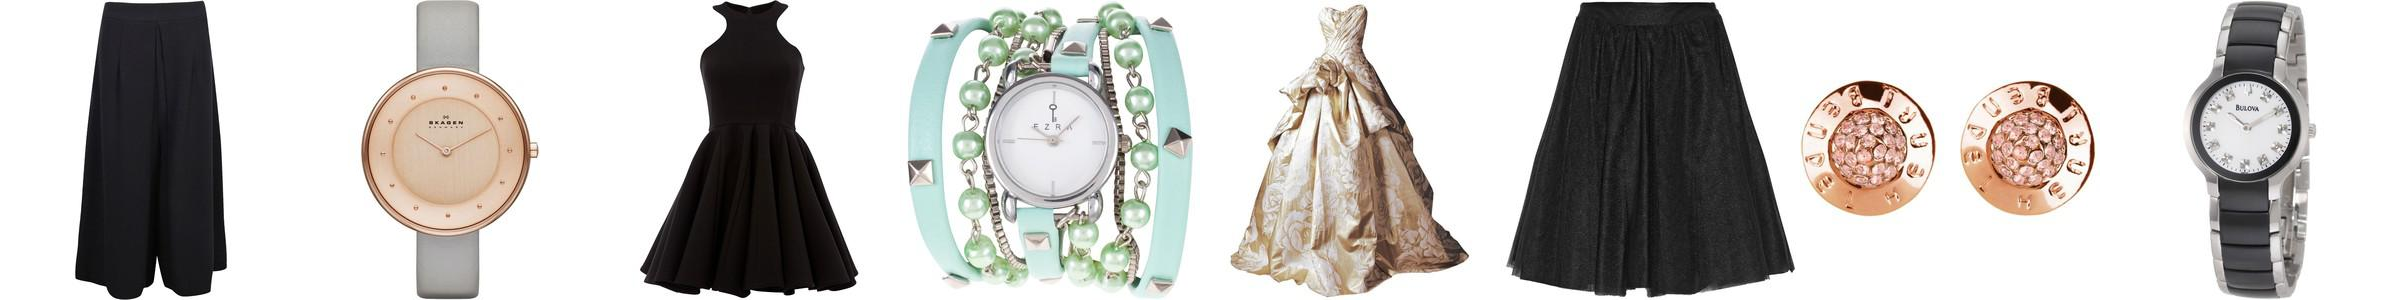

In [15]:
visualize_lsh(lsh_builder)

In [16]:
import os

def delete_item_from_lsh(item_name, lsh_builder):
    for table in lsh_builder.lsh.tables:
        for hash_val, entries in table.table.items():
            updated_entries = [entry for entry in entries if entry['image_name'] != item_name]
            table.table[hash_val] = updated_entries
            
    print(f"item '{item_name}' has been deleted from the LSH table.")


In [17]:
def process_and_add_image(image_path, lsh_builder):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Compute the hashes of the query image and fetch the results
    example_batch = dict(image=[image])
    hashes = lsh_builder.hash_fn(example_batch)["hashes"][0]

    # Add the image to the LSH table
    fileIdIndex = image_path.filename.find('.')
    fileId = ''
    if fileIdIndex != -1:
        fileId = image_path.filename[:fileIdIndex]
    
    lsh_builder.lsh.add(len(lsh_builder.lsh.tables[0].table), hashes, fileId)
    lsh_builder.save_lsh_table()
    print("Image processed and added successfully!")

In [18]:
!pip install flask
!pip install pillow
!pip install flask-ngrok


In [19]:
from flask import Flask, request, jsonify
from PIL import Image
import numpy as np
from flask_ngrok import run_with_ngrok

app = Flask(__name__)

run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/find_similar_images', methods=['POST'])
def find_similar_images():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'})
    
    pageIndex = int(request.args.get('pageIndex', 0))
    pageSize = int(request.args.get('pageSize', 5))

    print(pageIndex, pageSize)

    user_image = request.files['image']
    # user_image = "./saat.jpg"  

    new_image = np.array(Image.open(user_image))
    image_pil = Image.fromarray(new_image)

    results = lsh_builder.query(image_pil)
    print(results)

    image_names = []
    for _, info in results.items():
        image_name = os.path.splitext(info["image_name"])[0]
        image_names.append(image_name)

    # Implement pagination
    start_index = pageIndex * pageSize
    end_index = (pageIndex + 1) * pageSize
    paginated_results = image_names[start_index:end_index]

    return jsonify({'similar_images': paginated_results})

@app.route('/delete_item', methods=['POST'])
def delete_item():
    data = request.json
    if 'item_name' not in data:
        return jsonify({'success': False, 'error': 'Item name not provided'})

    item_name_to_delete = data['item_name']

    try:
        delete_item_from_lsh(item_name_to_delete, lsh_builder)
        return jsonify({'success': True, 'message': f'Item {item_name_to_delete} deleted successfully'})
    except Exception as e:
        return jsonify({'success': False, 'error': str(e)})


@app.route('/add_image', methods=['POST'])
def add_image():
    if 'image' not in request.files:
        return jsonify({'success': False, 'error': 'No image provided'})
    user_image = request.files['image']
    try:
        process_and_add_image(user_image, lsh_builder)
        return jsonify({'success': True, 'message': 'Image processed and added successfully'})
    except Exception as e:        
        return jsonify({'success': False, 'error': str(e)})


app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Exception in thread Thread-14:
Traceback (most recent call last):
  File "c:\Users\sahin\Desktop\deeplearning\test\midterm\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\sahin\Desktop\deeplearning\test\midterm\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\sahin\Desktop\deeplearning\test\midterm\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] Hedef makine etkin olarak reddettiğinden bağlantı kurulamadı

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\sahin\Desktop\deeplearning\test\midterm\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\sahin\Desktop\deeple